<a href="https://colab.research.google.com/github/antoniosql/cursoml/blob/master/Ejercicio%20Churn/Prediciendo_del_abandono_de_clientes_Paso_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![SolidQ](https://www.solidq.com/wp-content/uploads/2015/06/Logo-SolidQ-Web.gif)
# Prediciendo el abandono de clientes


## Cómo leer ficheros de Drive en lugar de subirlos al entorno volátil de Colaboratory

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Tenemos un escenario en el que queremos medir el ratio de abandono (Churn Rate) de nuestros clientes de Telco. Es un concepto especialmente importante en negocios que están basados en suscripciones.

en nuestro conjunto de datos de ejemplo, cada ocurrencia representa un cliente de una compañía telefónica. Cada columna contiene atributos de ese cliente, como los cargos incurridos por servicio, tiempo de duración de su cuenta o si el cliente es todavía clinete o no. 

## Importamos las clases y módulos necesarios

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

## Explorando los datos

In [0]:

df_abandonos = pd.read_csv("/content/gdrive/My Drive/Datos/TelcoChurn.csv" )

In [0]:
df_abandonos.head()
#tenemos 3333 observaciones, de ellas 483 tienen Churn = yes

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,71,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,113,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [0]:
#filtro = df_abandonos["Churn"]=="yes"
#df_abandonos.where(filtro, inplace = False).count()


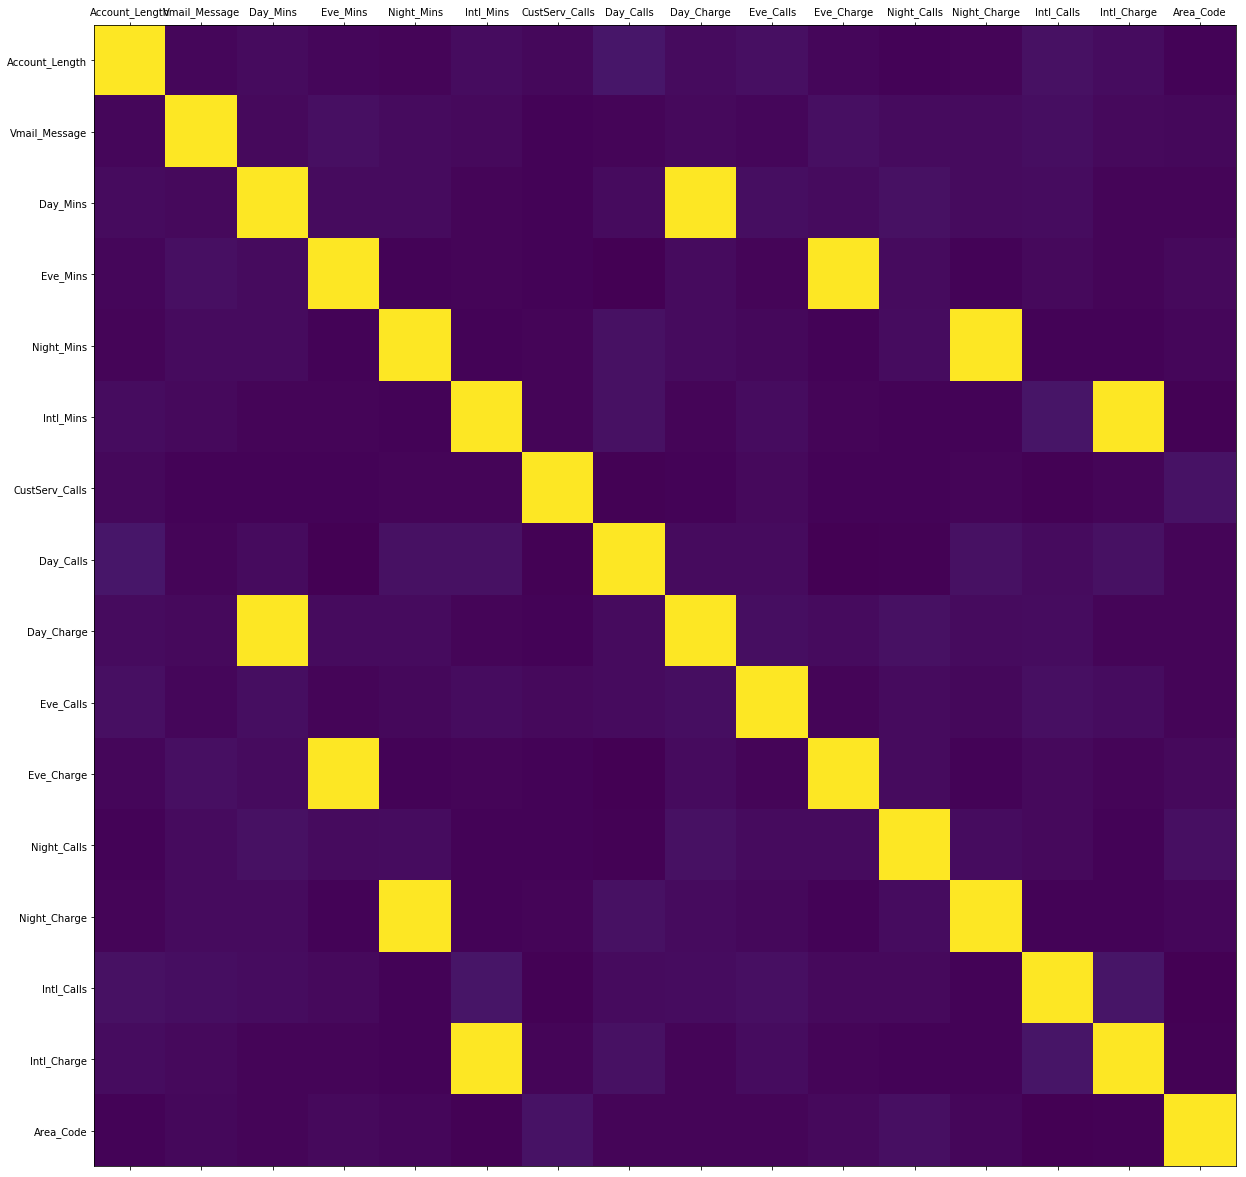

In [0]:
    correlacion = df_abandonos.corr() 
    fig, ax = plt.subplots(figsize=(21, 21)) 
    ax.matshow(correlacion) 
    plt.xticks(range(len(correlacion.columns)), correlacion.columns); 
    plt.yticks(range(len(correlacion.columns)), correlacion.columns); 

Es evidente que los cargos dependen de los minutos de conversación por lo que los pares de características x_calls x_Charge están muy correlacionadas entre sí

In [0]:

#Extraemos las etiquetas
resultado_abandono = df_abandonos['Churn']
y = np.where(resultado_abandono == 'yes',1,0)

# No necesitamos estas columnas
a_eliminar = ['State','Area_Code','Phone','Churn']
churn_feat_space = df_abandonos.drop(a_eliminar,axis=1)

yes_no_cols = ["Intl_Plan","Vmail_Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'


# Extrarmos características para su uso posterior

caracteristicas = churn_feat_space.columns

X = churn_feat_space.as_matrix().astype(np.float)

# Escalamos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print ("Disponemos de %d observaciones y %d características" % X.shape)
print ("Etiquetas objetivo únicas:", np.unique(y))


Disponemos de 3333 observaciones y 17 características
Etiquetas objetivo únicas: [0 1]


## Validación cruzada de Algoritmos

In [0]:
from sklearn.model_selection import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construir el objeto Kfolds
    kf = KFold(5)
    y_pred = y.copy()

    # Iterar por los Folds
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train], X[test]
        y_train = y[train]
        # Inicializar un clasificador con los argumentos clave
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test] = clf.predict(X_test)
    return y_pred

### Probamos los tres algoritmos

In [0]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN

def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print ("Support vector machines:")
print ("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print ("Random forest:")
print ("%.3f" % accuracy(y, run_cv(X,y,RF)))
print ("K-nearest-neighbors:")
print ("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Support vector machines:
0.919
Random forest:
0.943
K-nearest-neighbors:
0.893


### Matriz de Confusión

In [0]:
from sklearn.metrics import confusion_matrix

y = np.array(y)


confusion_matrix(y,run_cv(X,y,SVC))


array([[2815,   35],
       [ 236,  247]])

In [0]:
confusion_matrix(y,run_cv(X,y,RF)) 


array([[2828,   22],
       [ 166,  317]])

In [0]:
confusion_matrix(y,run_cv(X,y,KNN))

array([[2805,   45],
       [ 312,  171]])

## Agregando las probabilidades

In [0]:

def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(5)
    y_prob = np.zeros((len(y),2))
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train], X[test]
        y_train = y[train]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test] = clf.predict_proba(X_test)
    return y_prob

In [0]:
# Cómo podemos comprobar la validez de estas probabilidades??

import warnings
warnings.filterwarnings('ignore')

# Usar 10 estimadores por lo que las predicciones son todas múltiplos de 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Número de veces que na probabilidad predecida es asignada a una observación
counts = pd.value_counts(pred_churn)

# Cálculo de probabilidades verdaderas
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

#ordenación de resultados
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1772,0.024831
1,0.1,719,0.031989
2,0.2,256,0.058594
3,0.3,102,0.166667
4,0.4,83,0.337349
5,0.9,81,0.950617
6,0.8,79,0.974684
7,1.0,67,1.000000
8,0.6,63,0.698413
9,0.7,58,0.896552
